#  Heart failure prediction

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
)
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [3]:
heart_data = pd.read_csv("data/heart_unclean.csv")
heart_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40.0,M,ATA,140.0,289.0,0.0,Normal,172.0,N,0.0,Up,0.0
1,49.0,F,NAP,160.0,180.0,0.0,Normal,156.0,N,1.0,Flat,1.0
2,37.0,M,ATA,130.0,283.0,0.0,ST,98.0,N,0.0,Up,0.0
3,48.0,F,ASY,138.0,214.0,0.0,Normal,108.0,Y,1.5,NaN,1.0
4,54.0,M,NAP,150.0,NaN,0.0,Normal,122.0,N,0.0,Up,0.0


In [4]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             901 non-null    float64
 1   Sex             906 non-null    object 
 2   ChestPainType   900 non-null    object 
 3   RestingBP       899 non-null    float64
 4   Cholesterol     900 non-null    float64
 5   FastingBS       904 non-null    float64
 6   RestingECG      898 non-null    object 
 7   MaxHR           892 non-null    float64
 8   ExerciseAngina  896 non-null    object 
 9   Oldpeak         896 non-null    float64
 10  ST_Slope        897 non-null    object 
 11  HeartDisease    898 non-null    float64
dtypes: float64(7), object(5)
memory usage: 86.2+ KB


In [5]:
heart_data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,901.000000,899.000000,900.000000,904.000000,892.000000,896.000000,898.000000
mean,53.489456,132.395996,198.657778,0.231195,136.706278,0.876897,0.550111
std,9.452639,18.482551,109.555724,0.421830,25.481514,1.060458,0.497760
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,172.750000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.500000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,155.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [6]:
numeric_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak", "FastingBS"]
categorical_features = [
    "Sex",
    "ChestPainType",
    "RestingECG",
    "ExerciseAngina",
    "ST_Slope",
]

heart_num = heart_data[numeric_features]
heart_cat = heart_data[categorical_features]

## Generate Data Pipeline

In [7]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


set_config(display="diagram")
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'RestingBP', 'Cholesterol', 'MaxHR',
                                  'Oldpeak', 'FastingBS']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['Sex', 'ChestPainType', 'RestingECG',
                                  'ExerciseAngina', 'ST_Slope'])])

## Test and Training Split

In [8]:
X = heart_data.drop("HeartDisease", axis=1)
y = (heart_data["HeartDisease"]).apply(lambda x: bool(x))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
y_train = y_train.apply(lambda x: bool(x))

In [10]:
X_train_prepared = preprocessor.fit_transform(X_train)
X_train_prepared

array([[ 1.76078643,  0.41238503, -1.8723884 , ...,  1.        ,
         0.        ,  0.        ],
       [-0.82039138, -0.96073515, -1.8723884 , ...,  1.        ,
         0.        ,  0.        ],
       [ 1.22304105,  1.51088117,  1.50407484, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.36264845, -0.24671266,  0.96946816, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.11549198,  0.08283619,  0.68809622, ...,  0.        ,
         0.        ,  0.        ],
       [-0.71284231, -1.3452088 ,  0.40672428, ...,  0.        ,
         1.        ,  0.        ]])

### Klassifikation

In [23]:
transformed_column_names = list(
    preprocessor.transformers_[1][1].get_feature_names(categorical_features)
)

clf = SGDClassifier()
clf.fit(X_train_prepared, y_train)

/usr/lib64/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


SGDClassifier()

In [13]:
X_test_prepared = preprocessor.transform(X_test)
predicted = clf.predict(X_test_prepared)

precision = precision_score(y_pred=predicted, y_true=y_test)
accuracy = accuracy_score(y_pred=predicted, y_true=y_test)
recall = recall_score(y_pred=predicted, y_true=y_test)
f1score = f1_score(y_pred=predicted, y_true=y_test)

print(f"precision: {precision}")
print(f"recall: {recall}")

precision: 0.8
recall: 0.8888888888888888


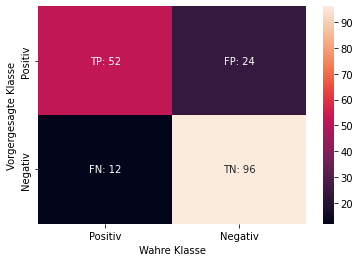

In [24]:
con_matrix = confusion_matrix(y_test, predicted)
ax = sns.heatmap(tf_confusion_matrix2, annot=True)
ax.set_xticklabels(("Positiv", "Negativ"))
ax.set_yticklabels(("Positiv", "Negativ"))
plt.xlabel("Wahre Klasse")
plt.ylabel("Vorgergesagte Klasse")
ax.texts[0].set_text("TP: " + ax.texts[0].get_text())
ax.texts[1].set_text("FP: " + ax.texts[1].get_text())
ax.texts[2].set_text("FN: " + ax.texts[2].get_text())
ax.texts[3].set_text("TN: " + ax.texts[3].get_text())